In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

sns.set_style("whitegrid")

# Data Loading, Cleaning, EDA

In [2]:
train_path = "dataset/delhi-climate-data/DailyDelhiClimateTrain.csv"
test_path = "dataset/delhi-climate-data/DailyDelhiClimateTest.csv"
df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)

def clean_df(df):
    return (df
        .loc[:, ["date", "meantemp"]]
        .sort_values("date", ascending=True)
        .assign(
            date=lambda df_: pd.to_datetime(df_["date"]), 
            meantemp=lambda df_: df_["meantemp"].astype("float32")
        )
        .set_index("date")
        .resample("1d")
        .ffill()
        .reset_index()
    )

df_train = clean_df(df_train)
df_test = clean_df(df_test)

print(df_train.shape, df_test.shape)

(1462, 2) (114, 2)


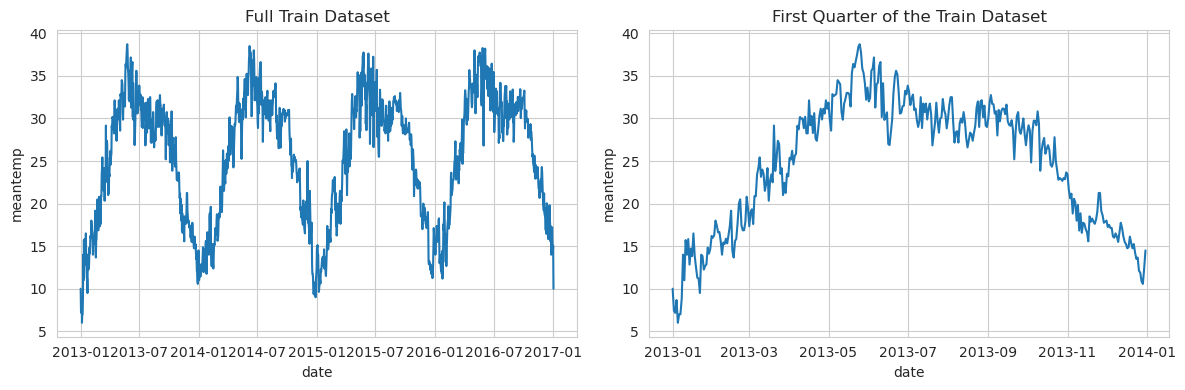

In [3]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

sns.lineplot(ax=axs[0], data=df_train, x="date", y="meantemp")
axs[0].set_title('Full Train Dataset')

sns.lineplot(ax=axs[1], data=df_train.iloc[:int(len(df_train)/4)], x="date", y="meantemp")
axs[1].set_title('First Quarter of the Train Dataset')

plt.tight_layout()
plt.show()

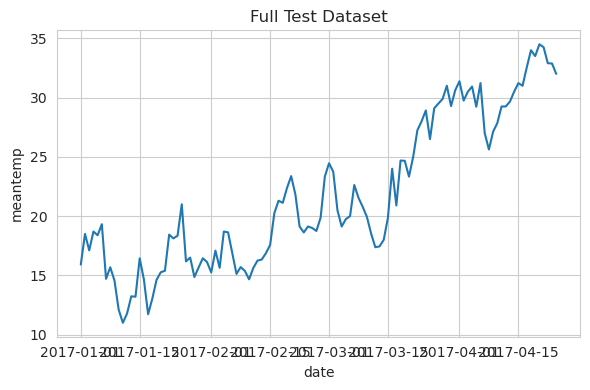

In [4]:
plt.figure(figsize=(6, 4))

sns.lineplot(data=df_test, x="date", y="meantemp")
plt.title('Full Test Dataset')

plt.tight_layout()
plt.show()

# Create Dataset

In [5]:
class TempDataset(Dataset):
    def __init__(self, data, sequence_length) -> None:
        self.data = data
        self.sequence_length = sequence_length

    def __len__(self) -> int:
        return len(self.data) - self.sequence_length

    def __getitem__(self, index):
        x = self.data[index : index + self.sequence_length].astype(np.float32)
        y = self.data[index + self.sequence_length].astype(np.float32)
        return x, y


train_temps = df_train["meantemp"].values[:1169]
val_temps = df_train["meantemp"].values[1169:]
test_temps = df_test["meantemp"].values

sequence_length = 12  # use 12 months prior to predict month #13
batch_size = 1

train_dataset = TempDataset(train_temps, sequence_length)
val_dataset = TempDataset(val_temps, sequence_length)
test_dataset = TempDataset(test_temps, sequence_length)
assert len(train_dataset) == (len(df_train.iloc[:1169]) - sequence_length)
assert len(val_dataset) == (len(df_train.iloc[1169:]) - sequence_length)
assert len(test_dataset) == (len(df_test) - sequence_length)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Check if the train dataset is correctly implemented.

In [6]:
for batch_idx, (inputs, targets) in enumerate(train_loader):
    print(f"Batch {batch_idx + 1}")
    print(f"Inputs shape: {inputs.shape}")  # Should be (batch_size, sequence_length)
    print(f"Targets shape: {targets.shape}")  # Should be (batch_size)
    print("Inputs:", inputs)
    print("Targets:", targets)

    break

Batch 1
Inputs shape: torch.Size([1, 12])
Targets shape: torch.Size([1])
Inputs: tensor([[10.0000,  7.4000,  7.1667,  8.6667,  6.0000,  7.0000,  7.0000,  8.8571,
         14.0000, 11.0000, 15.7143, 14.0000]])
Targets: tensor([15.8333])


In [7]:
train_temps[:13]

array([10.       ,  7.4      ,  7.1666665,  8.666667 ,  6.       ,
        7.       ,  7.       ,  8.857142 , 14.       , 11.       ,
       15.714286 , 14.       , 15.833333 ], dtype=float32)

In [8]:
np.array(inputs)

array([[10.       ,  7.4      ,  7.1666665,  8.666667 ,  6.       ,
         7.       ,  7.       ,  8.857142 , 14.       , 11.       ,
        15.714286 , 14.       ]], dtype=float32)

In [9]:
(np.array(inputs) == train_temps[:12]).all()

True

Do the same with test dataset.

In [10]:
test_targets = []
for batch_idx, (inputs, targets) in enumerate(test_loader):
    test_targets.append(np.array(targets))

np.array(test_targets).flatten()

array([13.235294, 13.2     , 16.434782, 14.65    , 11.722222, 13.041667,
       14.619047, 15.263158, 15.391304, 18.44    , 18.117647, 18.347826,
       21.      , 16.178572, 16.5     , 14.863636, 15.666667, 16.444445,
       16.125   , 15.25    , 17.09091 , 15.636364, 18.7     , 18.631578,
       16.88889 , 15.125   , 15.7     , 15.375   , 14.666667, 15.625   ,
       16.25    , 16.333334, 16.875   , 17.571428, 20.25    , 21.3     ,
       21.125   , 22.363636, 23.375   , 21.833334, 19.125   , 18.625   ,
       19.125   , 19.      , 18.75    , 19.875   , 23.333334, 24.461538,
       23.75    , 20.5     , 19.125   , 19.75    , 20.      , 22.625   ,
       21.545454, 20.785715, 19.9375  , 18.533333, 17.375   , 17.444445,
       18.      , 19.875   , 24.      , 20.9     , 24.692308, 24.666666,
       23.333334, 25.      , 27.25    , 28.      , 28.916666, 26.5     ,
       29.1     , 29.5     , 29.88889 , 31.      , 29.285715, 30.625   ,
       31.375   , 29.75    , 30.5     , 30.933332, 

In [11]:
test_temps[12:]

array([13.235294, 13.2     , 16.434782, 14.65    , 11.722222, 13.041667,
       14.619047, 15.263158, 15.391304, 18.44    , 18.117647, 18.347826,
       21.      , 16.178572, 16.5     , 14.863636, 15.666667, 16.444445,
       16.125   , 15.25    , 17.09091 , 15.636364, 18.7     , 18.631578,
       16.88889 , 15.125   , 15.7     , 15.375   , 14.666667, 15.625   ,
       16.25    , 16.333334, 16.875   , 17.571428, 20.25    , 21.3     ,
       21.125   , 22.363636, 23.375   , 21.833334, 19.125   , 18.625   ,
       19.125   , 19.      , 18.75    , 19.875   , 23.333334, 24.461538,
       23.75    , 20.5     , 19.125   , 19.75    , 20.      , 22.625   ,
       21.545454, 20.785715, 19.9375  , 18.533333, 17.375   , 17.444445,
       18.      , 19.875   , 24.      , 20.9     , 24.692308, 24.666666,
       23.333334, 25.      , 27.25    , 28.      , 28.916666, 26.5     ,
       29.1     , 29.5     , 29.88889 , 31.      , 29.285715, 30.625   ,
       31.375   , 29.75    , 30.5     , 30.933332, 

In [12]:
(np.array(test_targets).flatten() == test_temps[12:]).all()

True

In [13]:
test_inputs = []
for batch_idx, (inputs, targets) in enumerate(test_loader):
    test_inputs.append(np.array(inputs))

np.array(test_inputs)[-1]

array([[29.25    , 29.666666, 30.5     , 31.222221, 31.      , 32.555557,
        34.      , 33.5     , 34.5     , 34.25    , 32.9     , 32.875   ]],
      dtype=float32)

In [14]:
test_temps[-13:-1]

array([29.25    , 29.666666, 30.5     , 31.222221, 31.      , 32.555557,
       34.      , 33.5     , 34.5     , 34.25    , 32.9     , 32.875   ],
      dtype=float32)

In [15]:
(np.array(test_inputs)[-1] == test_temps[-13:-1]).all()

True

# Model Architecture

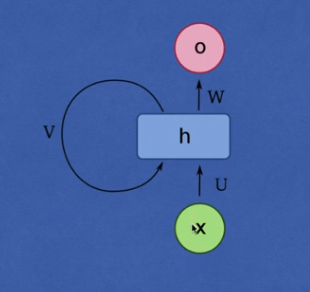

In [16]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.i2h = nn.Linear(
            in_features=(input_size + hidden_size), out_features=hidden_size
        )
        self.i2o = nn.Linear(in_features=hidden_size, out_features=output_size)
        self.relu = nn.ReLU()

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), dim=1)
        hidden = self.relu(self.i2h(combined))
        output = self.i2o(hidden)
        return output, hidden

    def init_hidden(self, batch_size):
        return torch.zeros(batch_size, self.hidden_size)


input_size = sequence_length
output_size = 1
hidden_size = 128
rnn = RNN(input_size, hidden_size, output_size)
rnn

RNN(
  (i2h): Linear(in_features=140, out_features=128, bias=True)
  (i2o): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

# Training

In [17]:
criterion = nn.MSELoss()
optimizer = optim.Adam(rnn.parameters(), lr=0.0005)


def train(inputs, target):
    rnn.train()
    hidden = rnn.init_hidden(batch_size)
    output, hidden = rnn(inputs, hidden)
    target = target.view(batch_size, output_size)
    loss = torch.sqrt(criterion(output, target))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss.item()


def validate(inputs, target):
    rnn.eval()
    with torch.no_grad():
        hidden = rnn.init_hidden(batch_size)
        output, hidden = rnn(inputs, hidden)
        target = target.view(batch_size, output_size)
        loss = torch.sqrt(criterion(output, target))

    return loss.item()


def predict(inputs):
    rnn.eval()
    with torch.no_grad():
        hidden = rnn.init_hidden(batch_size)
        output, hidden = rnn(inputs, hidden)
        return output

In [18]:
num_epochs = 50
print_step = 10

all_train_losses = []
all_val_losses = []

for epoch in range(num_epochs):

    train_losses = []
    val_losses = []

    for inputs, target in train_loader:
        loss = train(inputs, target)
        train_losses.append(loss)

    for inputs, target in val_loader:
        loss = validate(inputs, target)
        val_losses.append(loss)

    avg_train_loss = np.array(train_losses).mean()
    avg_val_loss = np.array(val_losses).mean()
    all_train_losses.append(avg_train_loss)
    all_val_losses.append(avg_val_loss)

    if (epoch == 0) or ((epoch + 1) % print_step == 0):
        print(
            f"Epoch {epoch+1: <3}/{num_epochs} | train RMSE = {avg_train_loss: .4f} | val RMSE = {avg_val_loss: .4f}"
        )

Epoch 1  /50 | train RMSE =  2.1071 | val RMSE =  1.7368
Epoch 10 /50 | train RMSE =  1.4504 | val RMSE =  1.3410
Epoch 20 /50 | train RMSE =  1.3620 | val RMSE =  1.3519
Epoch 30 /50 | train RMSE =  1.3138 | val RMSE =  1.4474
Epoch 40 /50 | train RMSE =  1.2852 | val RMSE =  1.2826
Epoch 50 /50 | train RMSE =  1.2710 | val RMSE =  1.3365


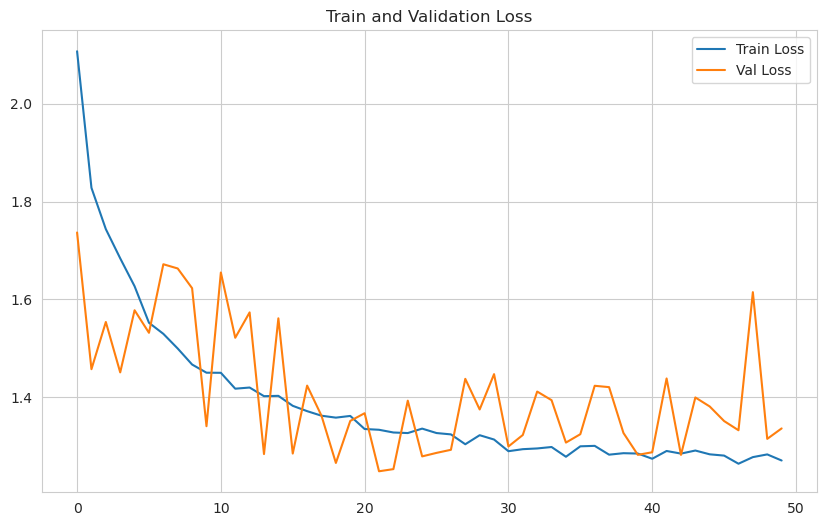

In [19]:
plt.figure(figsize=(10, 6))

sns.lineplot(x=range(len(all_train_losses)), y=all_train_losses, label="Train Loss")
sns.lineplot(x=range(len(all_val_losses)), y=all_val_losses, label="Val Loss")

plt.title("Train and Validation Loss")


plt.legend()
plt.show()

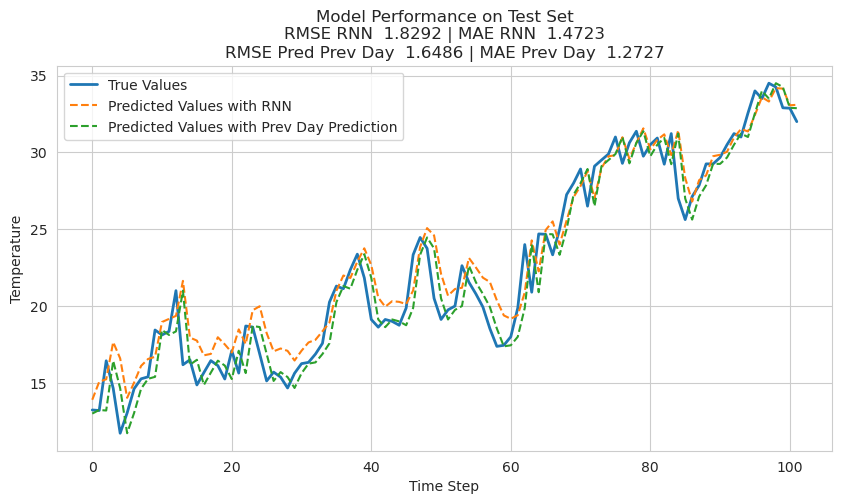

In [20]:
# prediction with RNN
y_true = []
y_pred = []

# hidden = rnn.init_hidden(batch_size)
for inputs, target in test_loader:
    output = predict(inputs)
    y_pred.append(output.item())
    y_true.append(target.item())

y_true = (np.array(y_true))
y_pred = (np.array(y_pred))
rnn_rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
rnn_mae = np.mean(abs(y_true - y_pred))

# prediction with prev day value
y_pred_prev_day = np.roll(y_true, 1)
y_pred_prev_day[0] = 13.0
rmse_prev_day_pred = np.sqrt(np.mean((y_true - y_pred_prev_day) ** 2))
mae_prev_day_pred = np.mean(abs(y_true - y_pred_prev_day))

# plot
plt.figure(figsize=(10, 5))
plt.plot(y_true, label="True Values", linewidth=2)
plt.plot(y_pred, label="Predicted Values with RNN", linestyle="--")
plt.plot(y_pred_prev_day, label="Predicted Values with Prev Day Prediction", linestyle="--")
plt.xlabel("Time Step")
plt.ylabel("Temperature")
plt.title(
    f"Model Performance on Test Set\nRMSE RNN {rnn_rmse: .4f} | MAE RNN {rnn_mae: .4f}\nRMSE Pred Prev Day {rmse_prev_day_pred: .4f} | MAE Prev Day {mae_prev_day_pred: .4f}"
)
plt.legend()
plt.show()